# Project Extension: User Movement in Location-Based Social Networks in Megalopolises

In this project extension, we are going to be focusing on the dataset containing location-based social networks of two densely populated cities: New York City and Tokyo.  Will be trying to answer similar questions as those explored in the article "Friendship and Mobility: User Movement in Location-Based Social Network".

Below you will find the following pipeline:
1. Loading and Pre-processing the data --> OK
2. Identifying User's Homes: A Change of Scale --> OK
3. Distribution of User's Check-ins as a function of distance traveled: Do users restrict themselves to their neighborhoods, or do travel further away ? --> OK
4. Is there a clear work/home routine? What are these New Yorker's and Tokyoite's habits?
5. What type of activities are the most popular, when and where are they done? (Is everyone gathered in SoHo??)
6. Are these trends comparable between megalopolises?

Link to dataset: https://sites.google.com/site/yangdingqi/home/foursquare-dataset

###### Importing the libraries needed for this project:

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns

import folium  # INSTALL FOLIUM
from folium import plugins

# Part 1: Loading and Pre-processing the Data

### <ins>Step 1</ins>: Loading the data

In [2]:
# Path
#DATA_FOLDER = '/Users/louiseplacidet/Desktop/ADA/Project/Extension/Data/'
DATA_FOLDER = './Data/'
NYC = DATA_FOLDER+'dataset_TSMC2014_NYC.txt'
TKY = DATA_FOLDER+'dataset_TSMC2014_TKY.txt'

# Loading data
nyc = pd.read_csv(NYC, header = None, sep='\t', engine='python',
                  names=['user_ID', 'venue_ID', 'venue_category_ID','venue_category_name',
                         'latitude', 'longitude', 'offset', 'UTC_time'])
tky = pd.read_csv(TKY, header = None, sep='\t', engine='python',
                  names=['user_ID', 'venue_ID', 'venue_category_ID','venue_category_name',
                         'latitude', 'longitude', 'offset', 'UTC_time'])

In [3]:
display(nyc.head(3))
display(tky.head(3))

,user_ID,venue_ID,venue_category_ID,venue_category_name,latitude,longitude,offset,UTC_time
0,470,49bbd6c0f964a520f4531fe3,4bf58dd8d48988d127951735,Arts & Crafts Store,40.719810,-74.002581,-240,Tue Apr 03 18:00:09 +0000 2012
1,979,4a43c0aef964a520c6a61fe3,4bf58dd8d48988d1df941735,Bridge,40.606800,-74.044170,-240,Tue Apr 03 18:00:25 +0000 2012
2,69,4c5cc7b485a1e21e00d35711,4bf58dd8d48988d103941735,Home (private),40.716162,-73.883070,-240,Tue Apr 03 18:02:24 +0000 2012


,user_ID,venue_ID,venue_category_ID,venue_category_name,latitude,longitude,offset,UTC_time
0,1541,4f0fd5a8e4b03856eeb6c8cb,4bf58dd8d48988d10c951735,Cosmetics Shop,35.705101,139.619590,540,Tue Apr 03 18:17:18 +0000 2012
1,868,4b7b884ff964a5207d662fe3,4bf58dd8d48988d1d1941735,Ramen / Noodle House,35.715581,139.800317,540,Tue Apr 03 18:22:04 +0000 2012
2,114,4c16fdda96040f477cc473a5,4d954b0ea243a5684a65b473,Convenience Store,35.714542,139.480065,540,Tue Apr 03 19:12:07 +0000 2012


In the two dataframes above, we are given additional information compared the dataframe in the replication project. Namely, we are given the "venue_category_name", which will enable us to draw more information about the habits of these New Yorkers and Tokyoites.

### <ins>Step 2</ins>: Pre-Processing the Data

###  1. Converting longitude and latitude into km values, and creating a grid

Similar to the Friendship and Mobility paper, we are estimating the home location of a user based on their check-in locations. This is accomplished by dividing our two cities into a grid, of size N by N km. N is the length of one unit in the grid and can be considered to be a design parameter. Indeed, we cannot use 25 km as we had previously done in the replication paper, given that we are working with a much denser dataset.

This is done by using the following conversions:

Latitude 1°: 110.574 km  
Longtiude: 1°: 111.320*cos(latitude) km

In [4]:
# The grid cells are discrete so we are rounding to the closest cell

def lat2km(lat, N):
    # Convert a latitude value to a N km grid
    km = np.round((110.574*lat)/N)
    return km
    
def long2km(long, lat, N):
    # Convert a longitude value to a N km grid 
    km = np.round((110.320 * long * np.cos(np.deg2rad(lat)))/N)
    return km
                  

In [5]:
N = 0.5 # Splitting into grid of N*N
nyc['x_grid'] = long2km(nyc.longitude, nyc.latitude, N)
nyc['y_grid'] = lat2km(nyc.latitude, N)

tky['x_grid'] = long2km(tky.longitude, tky.latitude, N)
tky['y_grid'] = lat2km(tky.latitude, N)

In [6]:
# Calculate distance between two pairs of long/lat coordinates. 
# Solution from: https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas/29546836#29546836

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km


### 2 . Getting the Local Time:

The time in the dataframe is the UTC time.  In order to compare the time that the activities were done in either New York or Tokyo, we need to convert the times into local times

In [7]:
def format_datetime(dt_series):

    def get_split_date(strdt):
        split_date = strdt.split()
        str_date = split_date[1] + ' ' + split_date[2] + ' ' + split_date[5] + ' ' + split_date[3]
        return str_date

    dt_series = pd.to_datetime(dt_series.apply(lambda x: get_split_date(x)), format = '%b %d %Y %H:%M:%S')

    return dt_series

In [8]:
nyc.UTC_time = format_datetime(nyc.UTC_time)
tky.UTC_time = format_datetime(tky.UTC_time)

In [9]:
nyc['local_time'] = nyc.apply(lambda x: x.UTC_time + dt.timedelta(minutes = x.offset), axis=1)
tky['local_time'] = tky.apply(lambda x: x.UTC_time + dt.timedelta(minutes = x.offset), axis=1)

In [10]:
nyc.head()

,user_ID,venue_ID,venue_category_ID,venue_category_name,latitude,longitude,offset,UTC_time,x_grid,y_grid,local_time
0,470,49bbd6c0f964a520f4531fe3,4bf58dd8d48988d127951735,Arts & Crafts Store,40.719810,-74.002581,-240,2012-04-03 18:00:09,-12375.0,9005.0,2012-04-03 14:00:09
1,979,4a43c0aef964a520c6a61fe3,4bf58dd8d48988d1df941735,Bridge,40.606800,-74.044170,-240,2012-04-03 18:00:25,-12403.0,8980.0,2012-04-03 14:00:25
2,69,4c5cc7b485a1e21e00d35711,4bf58dd8d48988d103941735,Home (private),40.716162,-73.883070,-240,2012-04-03 18:02:24,-12356.0,9004.0,2012-04-03 14:02:24
3,395,4bc7086715a7ef3bef9878da,4bf58dd8d48988d104941735,Medical Center,40.745164,-73.982519,-240,2012-04-03 18:02:41,-12367.0,9011.0,2012-04-03 14:02:41
4,87,4cf2c5321d18a143951b5cec,4bf58dd8d48988d1cb941735,Food Truck,40.740104,-73.989658,-240,2012-04-03 18:03:00,-12369.0,9010.0,2012-04-03 14:03:00


# Part 2: Identifying User's Homes: A Change of Scale

In the FourSquare Data, some of the check-ins are labeled as the user's home.  However, not all users have check-ins corresponding to their homes (for instance, it is not the case for user 1).  As a result, the method used in the replication paper will also be applied to estimate the home locations for users who do not have check-ins labeled as "Home (private)".

Moreover, for the users who do have such check-ins, it is interesting to compare the coordinates of that check-in to the approximation we can make using the method described in the replication paper.  This will enable us to get a feel for the accuracy of our computation!

###### The User's Homes According to FourSquare :

As stated above, some of the users don't have check-ins corresponding to their homes, as it is the case for user 1:

In [11]:
nyc[(nyc["user_ID"]==1)&(nyc["venue_category_name"]=="Home (private)")]

,user_ID,venue_ID,venue_category_ID,venue_category_name,latitude,longitude,offset,UTC_time,x_grid,y_grid,local_time


Moreover, in the table below, we can see that the users who do have check-ins corresponding to their homes, can have more than one check-in.  When comparing their latitude and longitude, they are quite close, and the home location assigned to the user will therefore be considered as the average of those.

In [12]:
# Retrieving all the homes check-ins
four_square_nyc_homes = nyc[nyc['venue_category_name'] == "Home (private)"][["user_ID", "venue_category_name", "latitude", "longitude"]] # Creating a dataframe with the home locations for the users
four_square_nyc_homes.set_index(["user_ID"], drop=True, inplace=True)
four_square_nyc_homes.sort_index(axis = 0, inplace = True) #Sorting this dataframe enables us to realize that some users have multiple check-ins related to their homes
display(four_square_nyc_homes.head(3))

four_square_tky_homes = tky[tky['venue_category_name'] == "Home (private)"][["user_ID", "venue_category_name", "latitude", "longitude"]] # Creating a dataframe with the home locations for the users
four_square_tky_homes.set_index(["user_ID"], drop=True, inplace=True)
four_square_tky_homes.sort_index(axis = 0, inplace = True) #Sorting this dataframe enables us to realize that some users have multiple check-ins related to their homes
display(four_square_tky_homes.head(3))

,venue_category_name,latitude,longitude
user_ID,,,
2,Home (private),40.625787,-74.153356
2,Home (private),40.562843,-73.918346
2,Home (private),40.625784,-74.082884


,venue_category_name,latitude,longitude
user_ID,,,
21,Home (private),35.705644,139.849608
21,Home (private),35.705644,139.849608
21,Home (private),35.705644,139.849608


In [13]:
# Taking the average if there are several ones for each user

four_square_nyc_homes = four_square_nyc_homes.groupby(by="user_ID")["latitude","longitude"].mean()
display(four_square_nyc_homes.head(3))

four_square_tky_homes = four_square_tky_homes.groupby(by="user_ID")["latitude","longitude"].mean()
display(four_square_tky_homes.head(3))

<ipython-input-13-bfed3c70e978>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  four_square_nyc_homes = four_square_nyc_homes.groupby(by="user_ID")["latitude","longitude"].mean()


,latitude,longitude
user_ID,,
2,40.594314,-74.018233
5,40.728001,-74.035888
6,40.833165,-73.941860


<ipython-input-13-bfed3c70e978>:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  four_square_tky_homes = four_square_tky_homes.groupby(by="user_ID")["latitude","longitude"].mean()


,latitude,longitude
user_ID,,
21,35.705644,139.849608
42,35.584788,139.594220
63,35.668599,139.772672


###### The User's Homes According to the replication paper's technique :

Using the technique described in the replication paper, we consider that the dataframes for the homes have the x and y coordinates for the cell within the grid with the most check-ins.  We then estimate the home position by using the average longitude and latitude for check-ins within this cell for each user.

In [14]:
# !!!!!!! FIIIIIXXX THE NANNNNNN PROOOOBLLEEEEMMMM in predicting the location of user's homes !!!!!!!!

In [15]:
# # The home locations can be obtained by counting the most common x and y cells for each user
# # This is done by storing the mode of each user's check-in cell's x and y coordinates.
nyc_homes = pd.DataFrame()
nyc_homes['x_cord'] = nyc.groupby(['user_ID'])['x_grid'].apply(pd.Series.mode)
nyc_homes['y_cord'] = nyc.groupby(['user_ID'])['y_grid'].apply(pd.Series.mode)
nyc_homes = nyc_homes.reset_index().drop(['level_1'], axis=1) # get rid of multiindex

tky_homes = pd.DataFrame()
tky_homes['x_cord'] = tky.groupby(['user_ID'])['x_grid'].apply(pd.Series.mode)
tky_homes['y_cord'] = tky.groupby(['user_ID'])['y_grid'].apply(pd.Series.mode)
tky_homes = tky_homes.reset_index().drop(['level_1'], axis=1)

In [16]:
# Combine the dataframes by merging on multiple columns; this keeps only the checkins in the 'home' cell. 
nyc_homes = pd.merge(nyc_homes, nyc, how = 'left', left_on=['user_ID', 'x_cord', 'y_cord'], right_on=['user_ID', 'x_grid', 'y_grid'])

# Obtain the mean longtitude and latitude for the users' estimated home location
nyc_homes = nyc_homes.groupby('user_ID')[['longitude', 'latitude']].mean()

tky_homes = pd.merge(tky_homes, tky, how = 'left', left_on=['user_ID', 'x_cord', 'y_cord'], right_on= ['user_ID', 'x_grid', 'y_grid'])
tky_homes = tky_homes.groupby('user_ID')[['longitude', 'latitude']].mean()

In [17]:
display(nyc_homes.head(3))
display(tky_homes.head(3))

,longitude,latitude
user_ID,,
1,-74.004165,40.719994
2,-73.913707,40.646648
3,-73.988551,40.745732


,longitude,latitude
user_ID,,
1,139.773418,35.698775
2,139.698197,35.658062
3,139.600839,35.668477


###### Checking Out the Accuracy of our Predictions :

In [18]:
comparing_homes_nyc = pd.merge(four_square_nyc_homes, nyc_homes, how='left', left_on=['user_ID'], right_on=['user_ID'],suffixes=["_foursquare","_approx"])
comparing_homes_nyc['latitude_accuracy'] = (comparing_homes_nyc['latitude_foursquare'] - comparing_homes_nyc['latitude_approx'])/comparing_homes_nyc['latitude_foursquare']
comparing_homes_nyc['longitude_accuracy'] = (comparing_homes_nyc['longitude_foursquare'] - comparing_homes_nyc['longitude_approx'])/comparing_homes_nyc['longitude_foursquare']
display(comparing_homes_nyc.sample(3))


comparing_homes_tky = pd.merge(four_square_tky_homes, tky_homes, how='left', left_on=['user_ID'], right_on=['user_ID'],suffixes=["_foursquare","_approx"])
comparing_homes_tky['latitude_accuracy'] = (comparing_homes_tky['latitude_foursquare'] - comparing_homes_tky['latitude_approx'])/comparing_homes_tky['latitude_foursquare']
comparing_homes_tky['longitude_accuracy'] = (comparing_homes_tky['longitude_foursquare'] - comparing_homes_tky['longitude_approx'])/comparing_homes_tky['longitude_foursquare']
display(comparing_homes_tky.sample(3))


,latitude_foursquare,longitude_foursquare,longitude_approx,latitude_approx,latitude_accuracy,longitude_accuracy
user_ID,,,,,,
313,40.656989,-73.953616,-73.962199,40.759233,-0.002515,-0.000116
304,40.740960,-73.918346,-73.919843,40.743133,-0.000053,-0.000020
506,40.693212,-73.930104,-73.942375,40.723767,-0.000751,-0.000166


,latitude_foursquare,longitude_foursquare,longitude_approx,latitude_approx,latitude_accuracy,longitude_accuracy
user_ID,,,,,,
1311,35.732010,139.482199,139.809107,35.734487,-0.000069,-0.002344
1292,35.704528,139.777988,139.700536,35.658632,0.001285,0.000554
1375,35.658610,139.777988,139.747722,35.730239,-0.002009,0.000217


In [19]:
#!!!!!!! FIND BETTER METRICS TO COMPUTE THE ACCURACYYYYY !!!!! SHOULD WE PROVIDE CONFIDENCE INTERVALS WITH BOOTSTRAP???

From the values in the dataframe above, the accuracy is very small, thus confirming that the prediction method provides accurate results.

###### Computing the final DataFrame containing the user's homes:

To construct the DataFrame containing the user's homes, we will use the home locations from FourSquare if they are provided.  In the absence of home check-ins, we will approximate as done in the replication paper:

In [20]:
# Merging the dataframe so that all users are present, and we associated to them their coordinates provided by foursquare (nan if there are none), and the approximated ones
final_nyc_homes = pd.merge(four_square_nyc_homes, nyc_homes, how='right', left_on=['user_ID'], right_on=['user_ID'], suffixes=['_foursquare','_approx'])

#Setting the coordinates to the foursquare values if they are provided, else tot the infered values
final_nyc_homes['latitude'] = np.where(np.isnan(final_nyc_homes['latitude_foursquare']), final_nyc_homes['latitude_approx'], final_nyc_homes['latitude_foursquare'])
final_nyc_homes['longitude'] = np.where(np.isnan(final_nyc_homes['longitude_foursquare']), final_nyc_homes['longitude_approx'], final_nyc_homes['longitude_foursquare'])
nyc_homes = final_nyc_homes # Renaming into the final dataframe that will be used from now on

# The same si done for Tokyo:
final_tky_homes = pd.merge(four_square_tky_homes, tky_homes, how='right', left_on=['user_ID'], right_on=['user_ID'], suffixes=['_foursquare','_approx'])
final_tky_homes['latitude'] = np.where(np.isnan(final_tky_homes['latitude_foursquare']), final_tky_homes['latitude_approx'], final_tky_homes['latitude_foursquare'])
final_tky_homes['longitude'] = np.where(np.isnan(final_tky_homes['longitude_foursquare']), final_tky_homes['longitude_approx'], final_tky_homes['longitude_foursquare'])
tky_homes = final_tky_homes # Renaming into the final dataframe that will be used from now on


# Renaming columns
nyc_homes = nyc_homes.add_suffix('_home')
tky_homes = tky_homes.add_suffix('_home')

display(nyc_homes.head(4))
display(tky_homes.head(4))

,latitude_foursquare_home,longitude_foursquare_home,longitude_approx_home,latitude_approx_home,latitude_home,longitude_home
user_ID,,,,,,
1,NaN,NaN,-74.004165,40.719994,40.719994,-74.004165
2,40.594314,-74.018233,-73.913707,40.646648,40.594314,-74.018233
3,NaN,NaN,-73.988551,40.745732,40.745732,-73.988551
4,NaN,NaN,-73.941512,40.816883,40.816883,-73.941512


,latitude_foursquare_home,longitude_foursquare_home,longitude_approx_home,latitude_approx_home,latitude_home,longitude_home
user_ID,,,,,,
1,NaN,NaN,139.773418,35.698775,35.698775,139.773418
2,NaN,NaN,139.698197,35.658062,35.658062,139.698197
3,NaN,NaN,139.600839,35.668477,35.668477,139.600839
4,NaN,NaN,139.759940,35.665565,35.665565,139.759940


# Part 3: Distribution of User's Check-ins as a function of distance traveled

In [21]:
# Merging homes with checkins 


#??? WHICH IS THE HOME LOCATION WE WANT?
nyc_checkin_homes = nyc.merge(nyc_homes[['latitude_home','longitude_home']], left_on='user_ID', right_index=True)
tky_checkin_homes = tky.merge(tky_homes[['latitude_home','longitude_home']], left_on='user_ID', right_index=True)

display(nyc_checkin_homes.head())
print(nyc.shape, nyc_homes.shape, nyc_checkin_homes.shape)

,user_ID,venue_ID,venue_category_ID,venue_category_name,latitude,longitude,offset,UTC_time,x_grid,y_grid,local_time,latitude_home,longitude_home
0,470,49bbd6c0f964a520f4531fe3,4bf58dd8d48988d127951735,Arts & Crafts Store,40.719810,-74.002581,-240,2012-04-03 18:00:09,-12375.0,9005.0,2012-04-03 14:00:09,40.71981,-74.002581
626,470,4e08ad8cd4c03ae0b9d11f93,4bf58dd8d48988d1d2941735,Sushi Restaurant,40.683178,-73.965746,-240,2012-04-03 23:36:34,-12376.0,8997.0,2012-04-03 19:36:34,40.71981,-74.002581
650,470,4be09b7fcb81c9b62069668b,4bf58dd8d48988d1d2941735,Sushi Restaurant,40.624513,-73.965070,-240,2012-04-03 23:46:46,-12386.0,8984.0,2012-04-03 19:46:46,40.71981,-74.002581
652,470,49f50c9ff964a5208a6b1fe3,4bf58dd8d48988d1d2941735,Sushi Restaurant,40.677611,-73.963748,-240,2012-04-03 23:47:16,-12376.0,8996.0,2012-04-03 19:47:16,40.71981,-74.002581
654,470,4a6a09b1f964a52071cc1fe3,4bf58dd8d48988d1d2941735,Sushi Restaurant,40.702752,-73.990696,-240,2012-04-03 23:47:49,-12376.0,9001.0,2012-04-03 19:47:49,40.71981,-74.002581


(227428, 11) (1083, 6) (227428, 13)


In [22]:
# Calculating distance traveled from home
nyc_checkin_homes['distance'] = haversine_np(nyc_checkin_homes['longitude'], nyc_checkin_homes['latitude'], 
                                      nyc_checkin_homes['longitude_home'], nyc_checkin_homes['latitude_home'])

tky_checkin_homes['distance'] = haversine_np(tky_checkin_homes['longitude'], tky_checkin_homes['latitude'], 
                                      tky_checkin_homes['longitude_home'], tky_checkin_homes['latitude_home'])

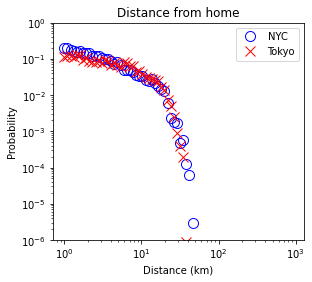

In [23]:
hist_nyc, bin_edges_nyc = np.histogram(nyc_checkin_homes['distance'], bins=np.logspace(np.log10(1),np.log10(1000.0), 75), density=True)
hist_tky, bin_edges_tky = np.histogram(tky_checkin_homes['distance'], bins=np.logspace(np.log10(1),np.log10(1000.0), 75), density=True)


plt.figure(figsize=(4.5,4))
plt.plot(bin_edges_nyc[:-1], hist_nyc, 'bo', bin_edges_tky[:-1], hist_tky, 'rx', mfc='none', ms=10)
plt.xscale('log')
plt.yscale('log')
plt.legend(['NYC', 'Tokyo'])
plt.title('Distance from home')
plt.xlabel('Distance (km)')
plt.ylabel('Probability')
plt.ylim([1e-6,1e0])
plt.show()

# Plotting the map

https://ngmdb.usgs.gov/topoview/viewer/#12/40.6875/-73.9375

https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm

https://medium.com/@ianforrest11/graphing-latitudes-and-longitudes-on-a-map-bf64d5fca391


Text(0, 0.5, 'latitude')

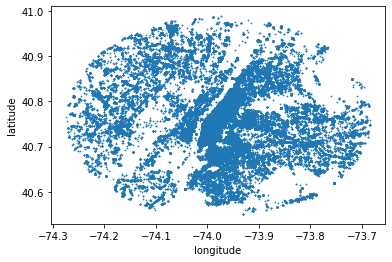

In [24]:
plt.scatter(nyc_checkin_homes['longitude'], nyc_checkin_homes['latitude'], s= 0.5)
plt.xlabel('longitude')
plt.ylabel('latitude')

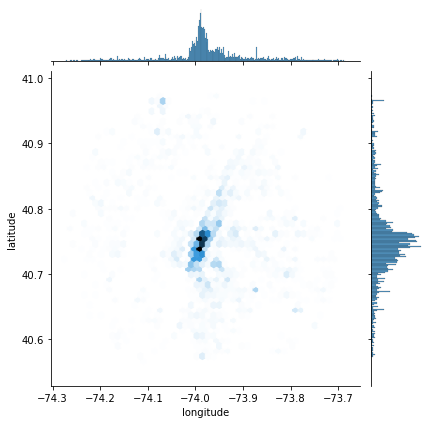

In [25]:
sns.jointplot(data = nyc_checkin_homes, x = 'longitude', y = 'latitude', kind="hex")

In [26]:
# import libraries

#INSTALL GEOPANDAS AND DESCARTES

import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt

In [27]:
# import street map
nyc_street_map = gpd.read_file('./nyc/geo_export_f26fc85a-8456-4e4a-887c-06898ab0ae9f.shp')
tky_street_map = gpd.read_file('./tky/japan_administrative.shp')

In [28]:
## Create geopandas dataframe

# designate coordinate system
crs = {'init':'espc:4326'}
# zip x and y coordinates into single feature
geometry = [Point(xy) for xy in zip(nyc['longitude'], nyc['latitude'])]  # we are joining latitude and longitude
# create GeoPandas dataframe
nyc_geo_df = gpd.GeoDataFrame(nyc, crs = crs, geometry = geometry)  # crs is the coordinate reference system

geometry = [Point(xy) for xy in zip(tky['longitude'], tky['latitude'])]  # we are joining latitude and longitude
# create GeoPandas dataframe
tky_geo_df = gpd.GeoDataFrame(tky, crs = crs, geometry = geometry)  # crs is the coordinate reference system



In [45]:
nyc_geo_df.head(2)

,user_ID,venue_ID,venue_category_ID,venue_category_name,latitude,longitude,offset,UTC_time,x_grid,y_grid,local_time,geometry
0,470,49bbd6c0f964a520f4531fe3,4bf58dd8d48988d127951735,Arts & Crafts Store,40.71981,-74.002581,-240,2012-04-03 18:00:09,-12375.0,9005.0,2012-04-03 14:00:09,POINT (-74.00258 40.71981)
1,979,4a43c0aef964a520c6a61fe3,4bf58dd8d48988d1df941735,Bridge,40.60680,-74.044170,-240,2012-04-03 18:00:25,-12403.0,8980.0,2012-04-03 14:00:25,POINT (-74.04417 40.60680)


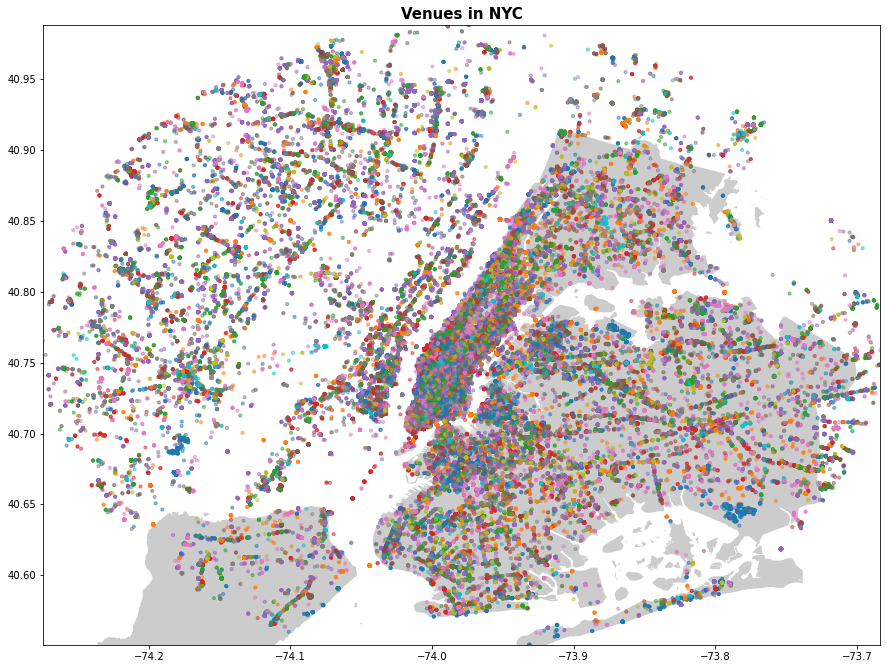

In [30]:
# Graph

fig, ax = plt.subplots(figsize=(15,15))
# add .shp mapfile to axes
nyc_street_map.plot(ax = ax, alpha=0.4, color='grey')
nyc_geo_df.plot(column='venue_category_name', ax=ax, alpha=0.5, legend=False, markersize=10)

plt.title('Venues in NYC', fontsize=15, fontweight='bold')
plt.xlim(min(nyc['longitude']), max(nyc['longitude']))
plt.ylim(min(nyc['latitude']), max(nyc['latitude']))
plt.show()

# Part 4:

# Part 5: What type of activities are the most popular, when and where are they done?

### 1. Visualizing checkins in time

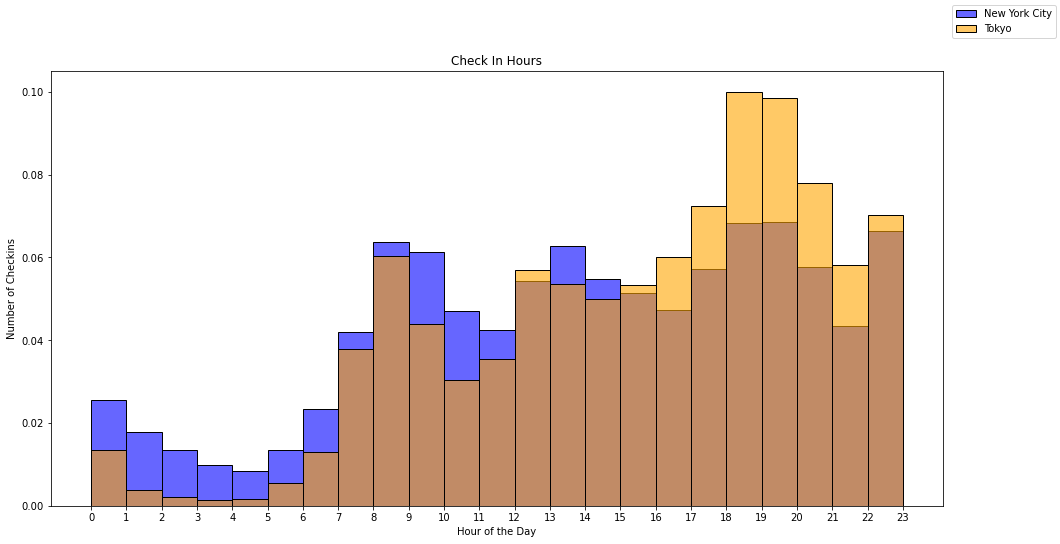

In [32]:
fig, ax = plt.subplots(figsize=(16,8))
sns.histplot(data = nyc, x = nyc.local_time.dt.hour, ax = ax, binwidth=1, color = 'blue', alpha = 0.6,
             stat = 'probability', label = 'New York City')
#sns.histplot(data = tky, x = tky.local_time.dt.hour, ax = ax, binwidth=1, color = 'orange', alpha = 0.6, label = 'Tokyo')
sns.histplot(data = tky, x = tky.local_time.dt.hour, ax = ax, binwidth=1, color = 'orange', alpha = 0.6,
             stat = 'probability', label = 'Tokyo')
fig.legend()
ax.set(title = 'Check In Hours', xlabel='Hour of the Day', ylabel ='Number of Checkins', xticks = np.arange(0,24));

# I decided to sample the tokyo data to normalize against the different size of the data sets
# Looking at the distribution of the data, we can see that NYC is more active in the early hours of the morning relative to Tokyo
# We can also see that people in Tokyo are more active in the early evening (5-9)

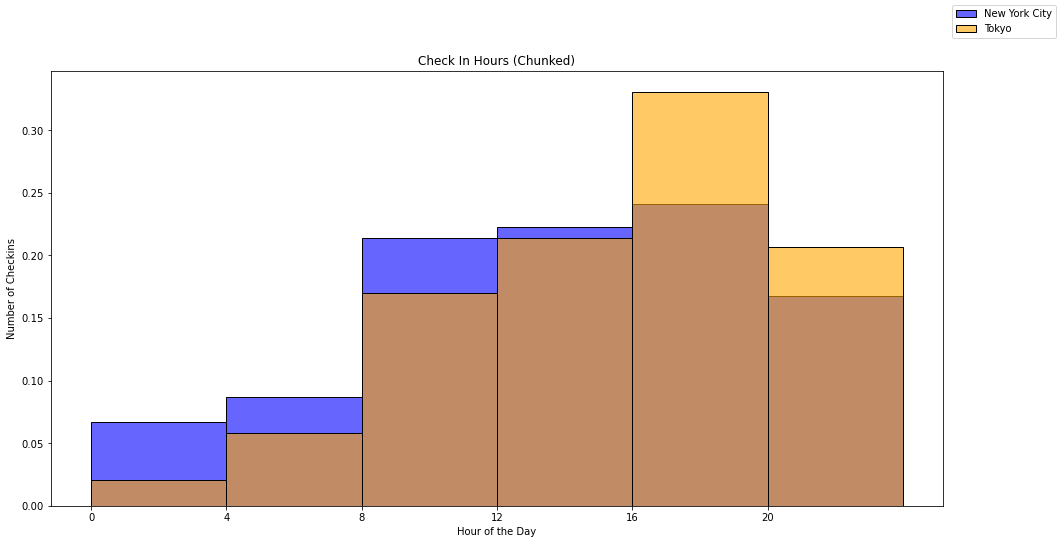

In [33]:
N = 4 # to group by hours

fig, ax = plt.subplots(figsize=(16,8))
sns.histplot(data = nyc, x = nyc.local_time.dt.hour, ax = ax, binwidth=N, color = 'blue', alpha = 0.6,
             stat = 'probability', label = 'New York City')
#sns.histplot(data = tky, x = tky.local_time.dt.hour, ax = ax, binwidth=1, color = 'orange', alpha = 0.6, label = 'Tokyo')
sns.histplot(data = tky, x = tky.local_time.dt.hour, ax = ax, binwidth=N, color = 'orange', alpha = 0.6,
             stat = 'probability', label = 'Tokyo')
fig.legend()
ax.set(title = 'Check In Hours (Chunked)', xlabel='Hour of the Day', ylabel ='Number of Checkins', xticks = np.arange(0,24,N));

# I decided to sample the tokyo data to normalize against the different size of the data sets
# Looking at the distribution of the data, we can see that NYC is more active in the early hours of the morning relative to Tokyo
# We can also see that people in Tokyo are more active in the early evening (5-9)

### 2. Visualizing types of activities

[Text(0.5, 1.0, 'Tokyo activities')]

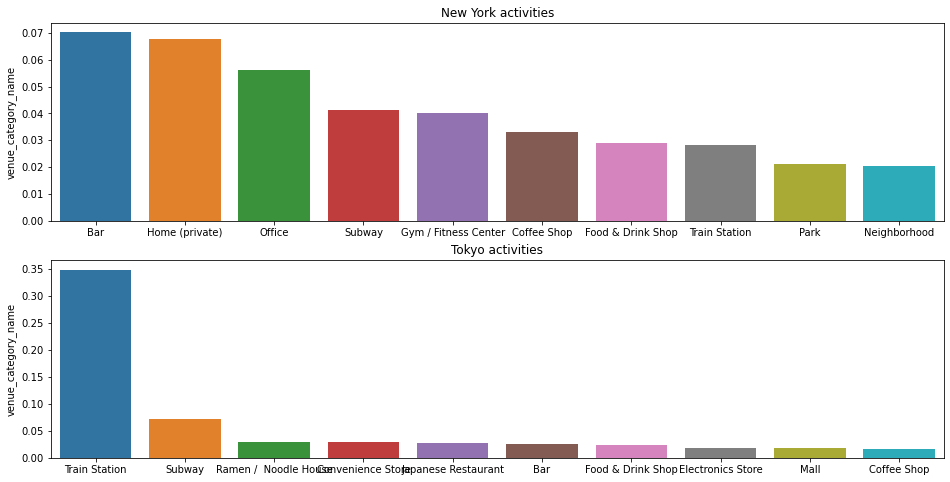

In [42]:
# What are the most popular types of venues?
nyc_pop_venues = nyc.venue_category_name.value_counts().nlargest(10);
tky_pop_venues = tky.venue_category_name.value_counts().nlargest(10);

fig, ax = plt.subplots(2, figsize=(16,8))
sns.barplot(x = nyc_pop_venues.keys(), y = nyc_pop_venues/len(nyc), ax = ax[0]).set(title='New York activities')
sns.barplot(x = tky_pop_venues.keys(), y = tky_pop_venues/len(tky), ax=ax[1]).set(title='Tokyo activities')

### 3. Are there certain check in locations that are more popular at different times of the day?

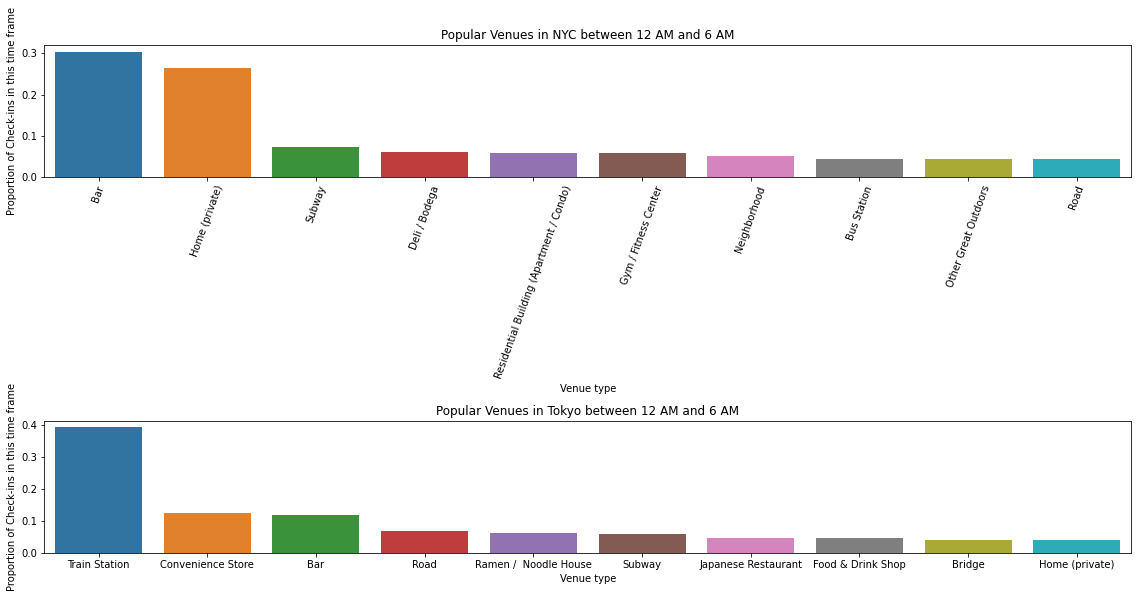

In [35]:
# Between midnight and 6 am
nyc_pop_venues = nyc.loc[nyc.local_time.dt.hour.isin(np.arange(1,6))].venue_category_name.value_counts().nlargest(10);
tky_pop_venues = tky.loc[tky.local_time.dt.hour.isin(np.arange(1,6))].venue_category_name.value_counts().nlargest(10);



fig, ax = plt.subplots(2, figsize=(16,8))
sns.barplot(x = nyc_pop_venues.keys(), y = nyc_pop_venues/np.sum(nyc_pop_venues), ax = ax[0])
sns.barplot(x = tky_pop_venues.keys(), y = tky_pop_venues/np.sum(tky_pop_venues), ax=ax[1]);
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=70)

ax[0].set(title = 'Popular Venues in NYC between 12 AM and 6 AM',
          xlabel = 'Venue type', ylabel = 'Proportion of Check-ins in this time frame')
ax[1].set(title = 'Popular Venues in Tokyo between 12 AM and 6 AM',
          xlabel = 'Venue type', ylabel = 'Proportion of Check-ins in this time frame')
plt.tight_layout()

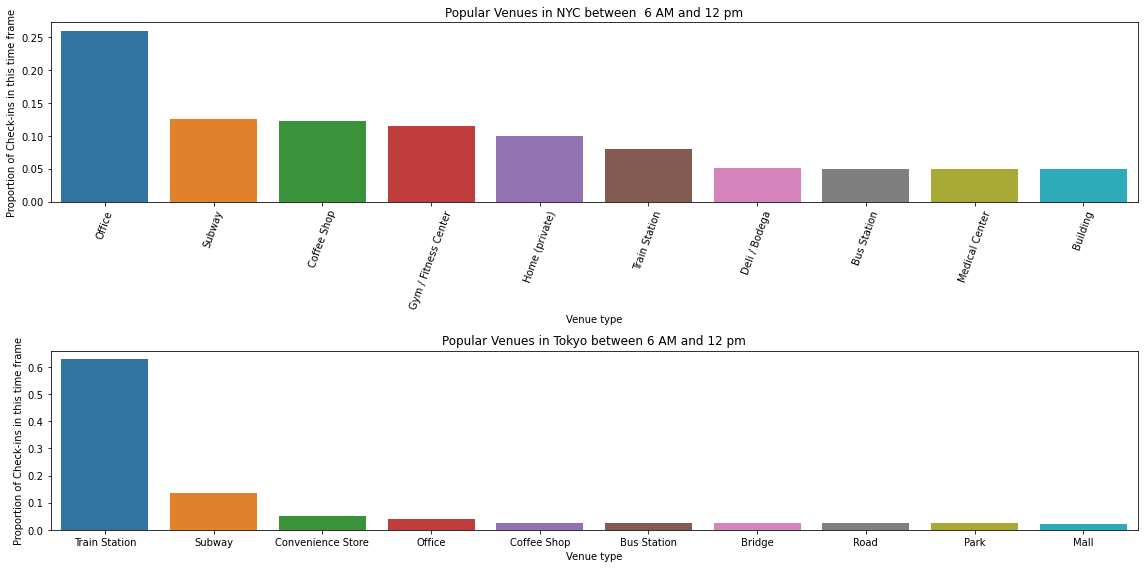

In [36]:
# Between 6 and 12 pm
nyc_pop_venues = nyc.loc[nyc.local_time.dt.hour.isin(np.arange(6,12))].venue_category_name.value_counts().nlargest(10);
tky_pop_venues = tky.loc[tky.local_time.dt.hour.isin(np.arange(6,12))].venue_category_name.value_counts().nlargest(10);



fig, ax = plt.subplots(2, figsize=(16,8))
sns.barplot(x = nyc_pop_venues.keys(), y = nyc_pop_venues/np.sum(nyc_pop_venues), ax = ax[0])
sns.barplot(x = tky_pop_venues.keys(), y = tky_pop_venues/np.sum(tky_pop_venues), ax=ax[1]);
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=70)

ax[0].set(title = 'Popular Venues in NYC between  6 AM and 12 pm',
          xlabel = 'Venue type', ylabel = 'Proportion of Check-ins in this time frame')
ax[1].set(title = 'Popular Venues in Tokyo between 6 AM and 12 pm',
          xlabel = 'Venue type', ylabel = 'Proportion of Check-ins in this time frame')
plt.tight_layout()

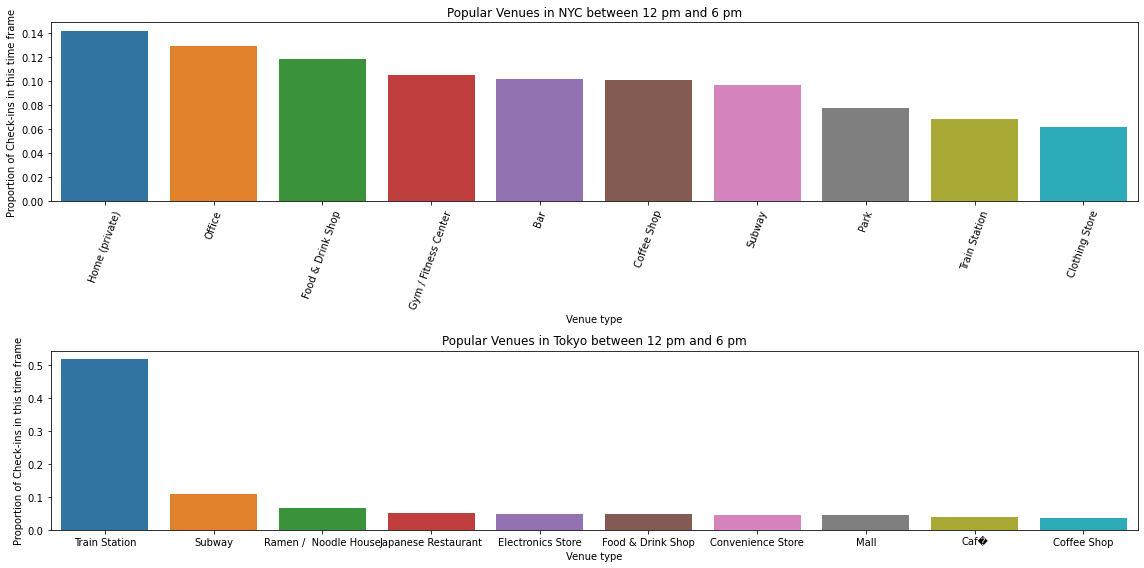

In [37]:
# Between 12 pm - 6 pm
nyc_pop_venues = nyc.loc[nyc.local_time.dt.hour.isin(np.arange(12,18))].venue_category_name.value_counts().nlargest(10);
tky_pop_venues = tky.loc[tky.local_time.dt.hour.isin(np.arange(12,18))].venue_category_name.value_counts().nlargest(10);



fig, ax = plt.subplots(2, figsize=(16,8))
sns.barplot(x = nyc_pop_venues.keys(), y = nyc_pop_venues/np.sum(nyc_pop_venues), ax = ax[0])
sns.barplot(x = tky_pop_venues.keys(), y = tky_pop_venues/np.sum(tky_pop_venues), ax=ax[1]);
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=70)

ax[0].set(title = 'Popular Venues in NYC between 12 pm and 6 pm',
          xlabel = 'Venue type', ylabel = 'Proportion of Check-ins in this time frame')
ax[1].set(title = 'Popular Venues in Tokyo between 12 pm and 6 pm',
          xlabel = 'Venue type', ylabel = 'Proportion of Check-ins in this time frame')
plt.tight_layout()

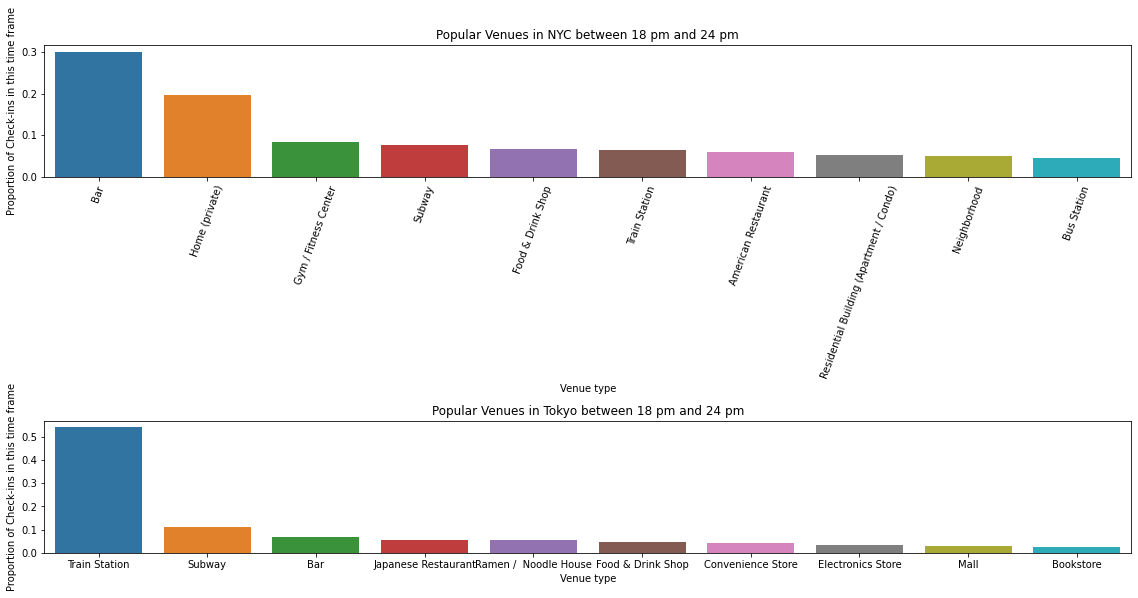

In [38]:
# Between 6 pm- midnight
nyc_pop_venues = nyc.loc[nyc.local_time.dt.hour.isin(np.arange(18,24))].venue_category_name.value_counts().nlargest(10);
tky_pop_venues = tky.loc[tky.local_time.dt.hour.isin(np.arange(18,24))].venue_category_name.value_counts().nlargest(10);



fig, ax = plt.subplots(2, figsize=(16,8))
sns.barplot(x = nyc_pop_venues.keys(), y = nyc_pop_venues/np.sum(nyc_pop_venues), ax = ax[0])
sns.barplot(x = tky_pop_venues.keys(), y = tky_pop_venues/np.sum(tky_pop_venues), ax=ax[1]);
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=70)

ax[0].set(title = 'Popular Venues in NYC between 18 pm and 24 pm',
          xlabel = 'Venue type', ylabel = 'Proportion of Check-ins in this time frame')
ax[1].set(title = 'Popular Venues in Tokyo between 18 pm and 24 pm',
          xlabel = 'Venue type', ylabel = 'Proportion of Check-ins in this time frame')
plt.tight_layout()

Train stations in Tokyo...

In [43]:
nyc.latitude.mean()

40.75404531077387

In [47]:
m = folium.Map([40.754, -73.974], zoom_start=11)

# convert to (n, 2) nd-array format for heatmap
nyc.loc[nyc.local_time.dt.hour.isin(np.arange(1,6))][['latitude', 'longitude']]

heatmap_locs = nyc.loc[nyc.local_time.dt.hour.isin(np.arange(1,6))][['latitude', 'longitude']].to_numpy()

# # plot heatmap
m.add_child(plugins.HeatMap(heatmap_locs, radius=10))
m


